# Pneumonia Detection by Fine-tuning VGG-16 using AWS Sagemaker 

**In this notebook we analyze a set of X-Ray images of patients suffering from pneumonia and we fine-tune an image recognition model to identify whether a new image belongs to a patient suffering from the disease. Tools used: AWS Sagemaker, AWS S3, PyTorch, Pandas** 

The performed steps are: 
1) Balance the dataset and perform the necessary normalization and transformation on the images.
2) Defining a set of hyperparameters to do hyperparamenter fine-tuning and the best combination.
3) Use the best combination of hyperparameters to re-train the model, this time with debugging and profiling enabled.
4) Deploying the trained predictor to an AWS Endpoint.

In [105]:
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


In [1]:
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Obtained from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [19]:
# Create an S3 client
s3 = boto3.client('s3')

# Get the SageMaker execution role
role = sagemaker.get_execution_role()

# Specify the bucket and file path
bucket = 'chest-pneumonia'
file_path = 'chest_xray.zip'

# Construct the S3 URI
s3_uri = f's3://{bucket}/{file_path}'

# Download the file to the local instance
s3.download_file(bucket, file_path, file_path)

In [1]:
!unzip chest_xray.zip;

Archive:  chest_xray.zip
  inflating: __MACOSX/._chest_xray   
  inflating: chest_xray/.DS_Store    
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: __MACOSX/chest_xray/._test  
   creating: chest_xray/train/
  inflating: __MACOSX/chest_xray/._train  
   creating: chest_xray/val/
  inflating: __MACOSX/chest_xray/._val  
  inflating: chest_xray/test/.DS_Store  
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/._PNEUMONIA  
   creating: chest_xray/test/NORMAL/
  inflating: __MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/train/.DS_Store  
  inflating: __MACOSX/chest_xray/train/._.DS_Store  
   creating: chest_xray/train/PNEUMONIA/
  inflating: __MACOSX/chest_xray/train/._PNEUMONIA  
   creating: chest_xray/train/NORMAL/
  inflating: __MACOSX/chest_xray/train/._NORMAL  
  inflating: chest_xray/val/.DS_Store  
  inflating: __MACOSX/chest_xray/val/._.DS_Store

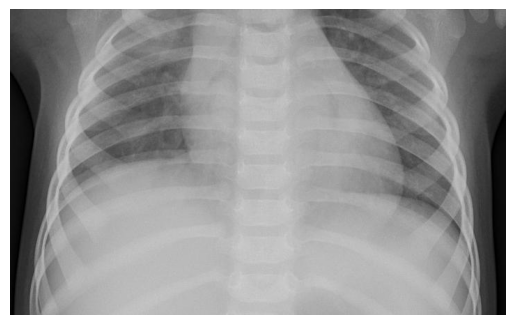

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample_image_path="chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg"

img = mpimg.imread(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

## Image Transformation and Normalization

In [106]:
import torch
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

In [107]:
data_dir='chest_xray'

# Define transformations
data_transforms = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

# Apply transformations to the dataset
train_dataset = ImageFolder(root=data_dir + '/train', transform=data_transforms)
val_dataset = ImageFolder(root=data_dir + '/val', transform=data_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

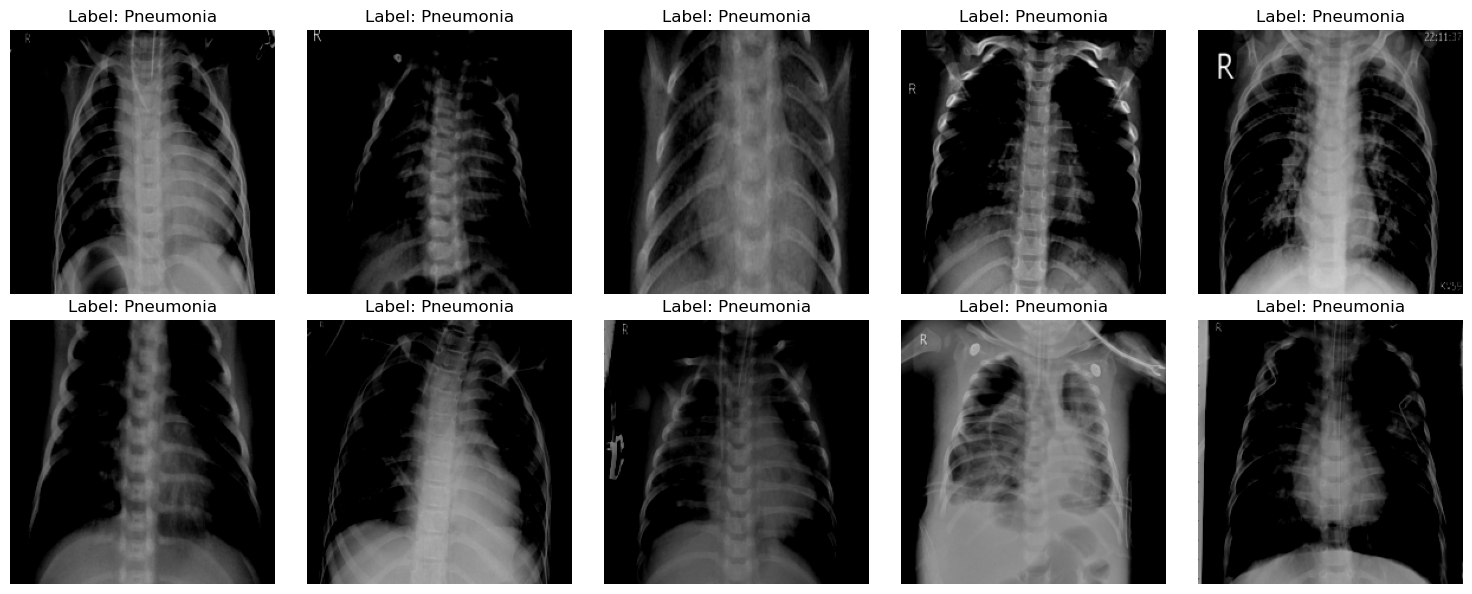

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choose 10 random samples from the transformed dataset
num_samples = 10
sample_indices = np.random.choice(len(train_dataset), num_samples, replace=False)

# Create a subplot grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Define labels
class_names = ['Normal', 'Pneumonia']

# Loop through the samples and plot each one
for i, idx in enumerate(sample_indices):
    # Get the image and label
    image, label = train_dataset[idx]
    
    # Convert tensor to numpy array
    image_np = image.numpy().transpose((1, 2, 0))
    
    # Plot the image
    axes[i].imshow(image_np)
    axes[i].set_title(f'Label: {class_names[label]}')  # Use class_names to map label to its corresponding class
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
train_dataset.classes

['NORMAL', 'PNEUMONIA']

## Fix class imbalance

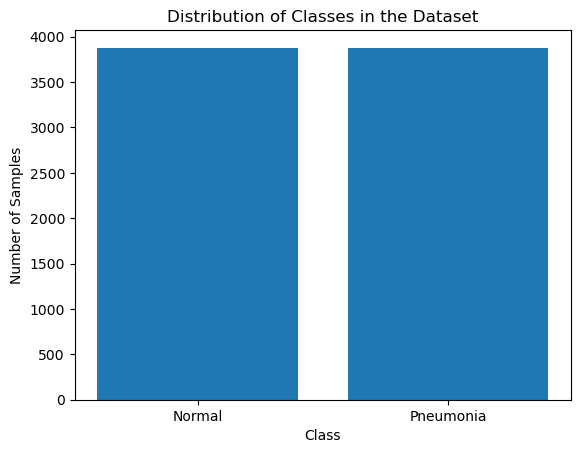

In [108]:
import matplotlib.pyplot as plt

# Map original labels to desired class names
class_names = {0: 'Normal', 1: 'Pneumonia'}

# Convert labels to class names
class_names_labels = [class_names[label] for _, label in train_dataset]

# Count the number of samples for each class
class_counts = {class_name: class_names_labels.count(class_name) for class_name in class_names.values()}

# Plot the bar chart
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in the Dataset')
plt.show()

It's evident that number of 'pneumonia' classes is considerably higher than 'Normal'. We solve this by cloning some of the existing 'Normal' samples and applying minor transformations to them until we obtain the same number of samples as the pneumonia category.

In [22]:
import os
import random
from tqdm import tqdm
from PIL import Image
import torchvision
from torchvision import transforms

# Define the directory paths for the two classes
normal_dir = 'chest_xray/train/NORMAL'
pneumonia_dir = 'chest_xray/train/PNEUMONIA'

# Get the list of file names in each directory
normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.jpeg') or f.endswith('.jpg')]
pneumonia_files = [f for f in os.listdir(pneumonia_dir) if f.endswith('.jpeg') or f.endswith('.jpg')]

# Display the original class distribution
print("Original class distribution:")
print("NORMAL samples:", len(normal_files))
print("PNEUMONIA samples:", len(pneumonia_files))

# Define the number of new samples to generate
num_new_samples = len(pneumonia_files) - len(normal_files)

# Define the directory to store the new samples
new_normal_dir = 'chest_xray/train/NEW_NORMAL'
os.makedirs(new_normal_dir, exist_ok=True)

# Define PyTorch transformations
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# Generate new samples
for i in tqdm(range(num_new_samples)):
    # Choose a random existing sample
    random_sample = random.choice(normal_files)
    
    # Read the image
    img_path = os.path.join(normal_dir, random_sample)
    
    # Apply transformations
    img = Image.open(img_path)
    transformed_img = data_transforms(img)
    
    # Save the transformed image
    new_sample_path = os.path.join(new_normal_dir, f'new_normal_{i}.jpeg')
    torchvision.utils.save_image(transformed_img, new_sample_path)

# Display the class distribution after generating new samples
new_normal_files = os.listdir(new_normal_dir)
print("\nClass distribution after generating new samples:")
print("NORMAL samples:", len(new_normal_files))
print("PNEUMONIA samples:", len(pneumonia_files))


Original class distribution:
NORMAL samples: 1341
PNEUMONIA samples: 3875


100%|██████████| 2534/2534 [01:02<00:00, 40.81it/s]


Class distribution after generating new samples:
NORMAL samples: 2534
PNEUMONIA samples: 3875


In [23]:
import os
import shutil

# Define the directories
normal_dir = 'chest_xray/train/NORMAL'
new_normal_dir = 'chest_xray/train/NEW_NORMAL'

# Copy files from NEW_NORMAL to NORMAL
new_normal_files = os.listdir(new_normal_dir)
for file in new_normal_files:
    src = os.path.join(new_normal_dir, file)
    dst = os.path.join(normal_dir, file)
    shutil.copyfile(src, dst)

# Remove NEW_NORMAL directory
shutil.rmtree(new_normal_dir)

# Display confirmation message
print("Files copied successfully from NEW_NORMAL to NORMAL directory.")

Files copied successfully from NEW_NORMAL to NORMAL directory.


In [24]:
train_dataset = ImageFolder(root=data_dir + '/train')

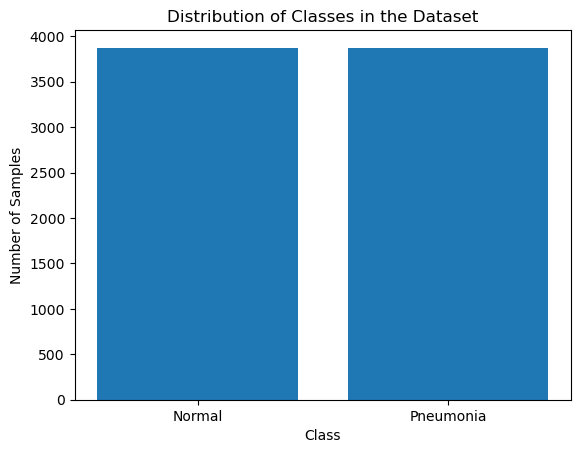

In [25]:
class_names_labels = [class_names[label] for _, label in train_dataset]

# Count the number of samples for each class
class_counts = {class_name: class_names_labels.count(class_name) for class_name in class_names.values()}

# Plot the bar chart
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in the Dataset')
plt.show()

Now we've got a balanced dataset =)!. We then upload the new samples to our S3 bucket.

In [5]:
bucket = 'sagemaker-us-east-1-854960079980'
sagemaker_session = sagemaker.Session()

In [6]:
prefix = 'data/chest_xray'
inputs = sagemaker_session.upload_data(path="chest_xray", bucket=bucket, key_prefix=prefix)

In [7]:
data_path = f"s3://{bucket}/data/chest_xray"

dataset = {
    'train': data_path +'/train',
    'val': data_path +'/val',
    'test': data_path +'/test'
}

In [8]:
os.environ['SM_CHANNEL_TRAIN'] = dataset['train']
os.environ['SM_CHANNEL_VAL'] = dataset['val']
os.environ['SM_CHANNEL_TEST'] = dataset['test']

In [9]:
s3_output_dir = f"s3://{bucket}/output"
s3_model_dir = f"s3://{bucket}/model"

os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir

## Hyperparameter Tuning

We perform hyperparameter tuning to systematically search for the optimal set of hyperparameters that result in the best performance of this model. The model is located in `hpo.py` and will be executed as a training job using AWS Estimator, the following is just a quick way to test the script before running the training job.

In [74]:
!python hpo.py \
    --batch_size 2 \
    --train chest_xray/train \
    --val chest_xray/val \
    --lr 0.001 \
    --momentum=0.9 \
    --epochs 1 

Running on Device cpu
Running on Device cpu
INFO:__main__:Running on Device cpu
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Finished getting the base model
Finished getting the base model
INFO:__main__:Finished getting the base model
hyperparams: Namespace(batch_size=2, epochs=1, lr=0.001, momentum=0.9, optimizer='adam', model_dir='s3://sagemaker-us-east-1-854960079980/model', output_dir='s3://sagemaker-us-east-1-8549600799

In [8]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.01),  # Learning rate range suitable for fine-tuning
    "batch_size": CategoricalParameter([32, 64, 128]),  # Batch size
    "momentum": ContinuousParameter(0.7, 0.99),  # Momentum range
    "optimizer": CategoricalParameter(['sgd', 'adam'])  # Optimizer choice
}

objective_metric_name = "Test Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Test Accuracy", "Regex": "Test Accuracy: ([0-9\\.]+)"}]

In [76]:
import sagemaker

role = sagemaker.get_execution_role()

# Create PyTorch estimator
estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    framework_version='1.8.1',
    py_version='py36',
    instance_count=1,
    instance_type='ml.g4dn.xlarge' # smallest with GPU 
)

# Create HyperparameterTuner
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    metric_definitions=metric_definitions,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=4,
    max_parallel_jobs=2,
)

In [77]:
tuner.fit(dataset, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-240611-1553


..........................................................................................................................................................................................................................................................................................................................................!


In [78]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-06-11 16:21:50 Starting - Found matching resource for reuse
2024-06-11 16:21:50 Downloading - Downloading the training image
2024-06-11 16:21:50 Training - Training image download completed. Training in progress.
2024-06-11 16:21:50 Uploading - Uploading generated training model
2024-06-11 16:21:50 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Accuracy"',
 'batch_size': '"64"',
 'lr': '0.0017841126099727884',
 'momentum': '0.7596033905508165',
 'optimizer': '"adam"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-06-11-15-53-42-824"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-11-15-53-42-824/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters we create and finetune a new model, this time adding model profiling and debugging.
The new model is located in `train_model.py`.

In [109]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig
import sagemaker
from sagemaker.pytorch import PyTorch

# Define rules
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

# Define profiler configuration
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

# Define debugger configuration
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "5"}
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [116]:
!python train_model.py \
    --batch_size 2 \
    --train chest_xray/train \
    --val chest_xray/val \
    --lr 0.001 \
    --momentum=0.9 \
    --epochs 1 

Running on Device cpu
Running on Device cpu
INFO:__main__:Running on Device cpu
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Finished getting the base model
Finished getting the base model
INFO:__main__:Finished getting the base model
hyperparams: Namespace(batch_size=2, epochs=1, lr=0.001, momentum=0.9, optimizer='adam', model_dir='s3://sagemaker-us-east-1-854960079980/model', output_dir='s3://sagemaker-us-east-1-8549600799

In [82]:
best_hyperparameters = best_estimator.hyperparameters()
print(best_hyperparameters)

{'_tuning_objective_metric': '"Test Accuracy"', 'batch_size': '"64"', 'lr': '0.0017841126099727884', 'momentum': '0.7596033905508165', 'optimizer': '"adam"', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2024-06-11-15-53-42-824"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-11-15-53-42-824/source/sourcedir.tar.gz"'}


In [117]:
hyperparameters = {
    "batch_size": 64,
    "lr": 0.0017841126099727884,
    "momentum": 0.7596033905508165,
    "optimizer": "adam"
}

In [118]:
role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    framework_version='1.8.1',
    py_version='py36',
    instance_count=1,
    hyperparameters=hyperparameters,
    instance_type='ml.g4dn.xlarge', # smallest with GPU
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [124]:
estimator.fit(dataset, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-06-23-16-58-32-410


2024-06-23 16:58:32 Starting - Starting the training job...
2024-06-23 16:58:48 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-06-23 16:59:25 Downloading - Downloading input data......
2024-06-23 17:00:25 Downloading - Downloading the training image..................
2024-06-23 17:03:26 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-06-23 17:03:32,430 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-06-23 17:03:32,458 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-06-23 17:03:32,463 sagemaker_pytorch_container.training INFO     Invoking user training scr

In [125]:
from smdebug.trials import create_trial

session = boto3.session.Session()
region = session.region_name
client = estimator.sagemaker_session.sagemaker_client

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

Training jobname: pytorch-training-2024-06-23-16-58-32-410
Region: us-east-1


{'TrainingJobName': 'pytorch-training-2024-06-23-16-58-32-410',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:854960079980:training-job/pytorch-training-2024-06-23-16-58-32-410',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '64',
  'lr': '0.0017841126099727884',
  'momentum': '0.7596033905508165',
  'optimizer': '"adam"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2024-06-23-16-58-32-410"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.1-gpu-py36',
  'TrainingInput

In [126]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())

[2024-06-23 17:10:34.110 default:117 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/debug-output
[2024-06-23 17:10:34.411 default:117 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-06-23 17:10:35.430 default:117 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/VGG_classifier.6.0.bias', 'gradient/VGG_classifier.6.0.weight', 'gradient/VGG_classifier.6.2.bias', 'gradient/VGG_classifier.6.2.weight']


In [127]:
from smdebug.core.modes import ModeKeys

print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


2
1


In [128]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [129]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 8))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

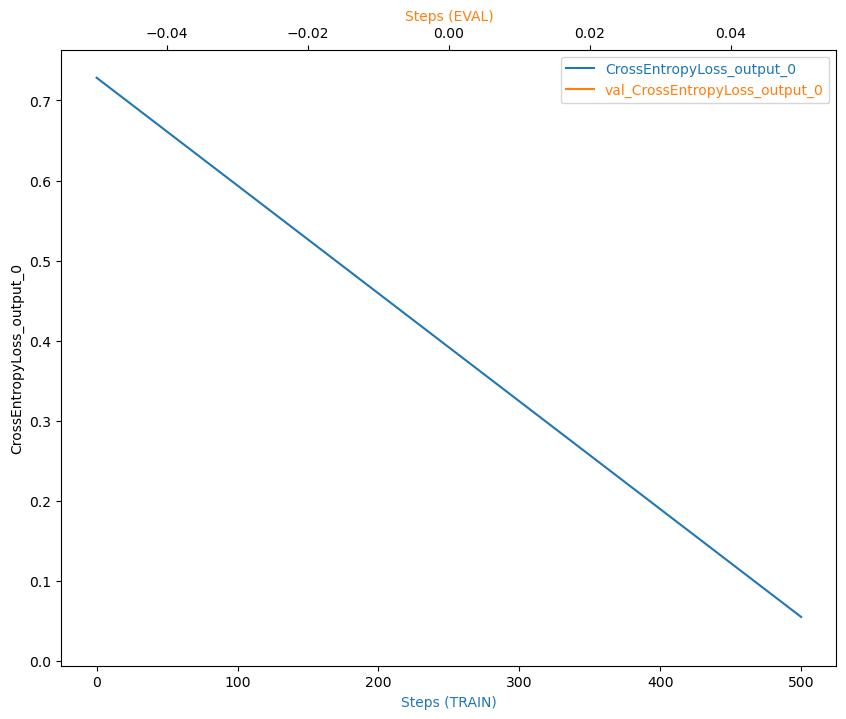

In [130]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [131]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2024-06-23 17:09:41     415715 pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-06-23 17:09:40     270340 pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-06-23 17:09:35        192 pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-06-23 17:09:35       9091 pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-06-23 17:09:35       2388 pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-06-23 17:09:35        330 pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-06-23 17:09:35       1096 pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-re

In [132]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-854960079980/pytorch-training

In [133]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [134]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying
We deploy the model to an AWS Endpoint so that we can easily predict our images.

In [135]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel


jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [136]:
pytorch_model = PyTorchModel(model_data=estimator.model_data, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor
                            )

In [164]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-854960079980/pytorch-training-2024-06-23-16-58-32-410/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-854960079980/pytorch-inference-2024-06-23-17-12-34-356/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-06-23-17-42-07-552
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-06-23-17-42-08-743
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-06-23-17-42-08-743


--------------!

In [157]:
image_path = "chest_xray/test/PNEUMONIA/person1_virus_11.jpeg"

In [158]:
from PIL import Image
import torchvision.transforms as transforms
import torch

image = Image.open(image_path)

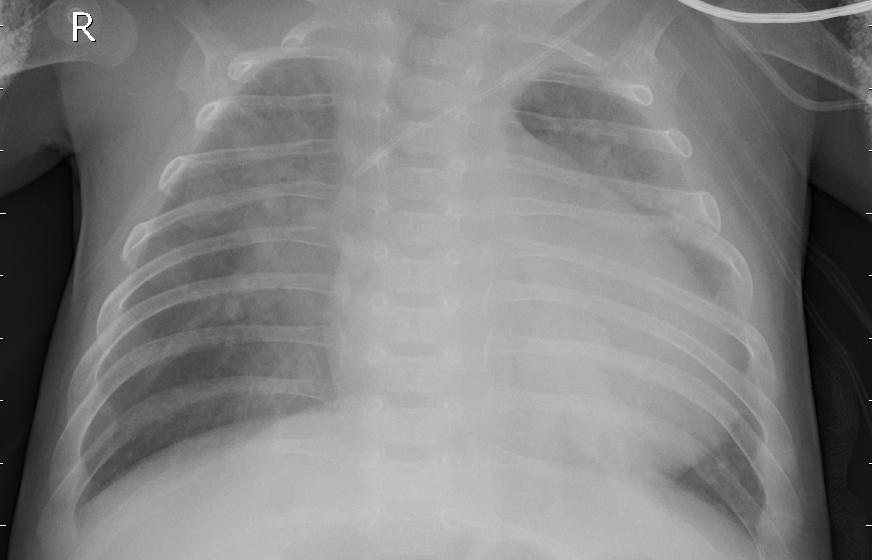

In [159]:
image

In [160]:
import io
image_bytes = io.BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

In [142]:
!python inference.py ## Just a sanity check to make sure there aren't any gross errors in the script
    

In [161]:
response = predictor.predict(data = image_bytes)

In [162]:
response

{'prediction': 'PNEUMONIA'}

In [163]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-06-23-17-12-35-112
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-06-23-17-12-35-112
